<a href="https://colab.research.google.com/github/chul1234/AI-project/blob/main/%EA%B3%B5%EB%AA%A8%EC%A0%84_%EC%BD%94%EB%93%9C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV #Import GridSearchCV

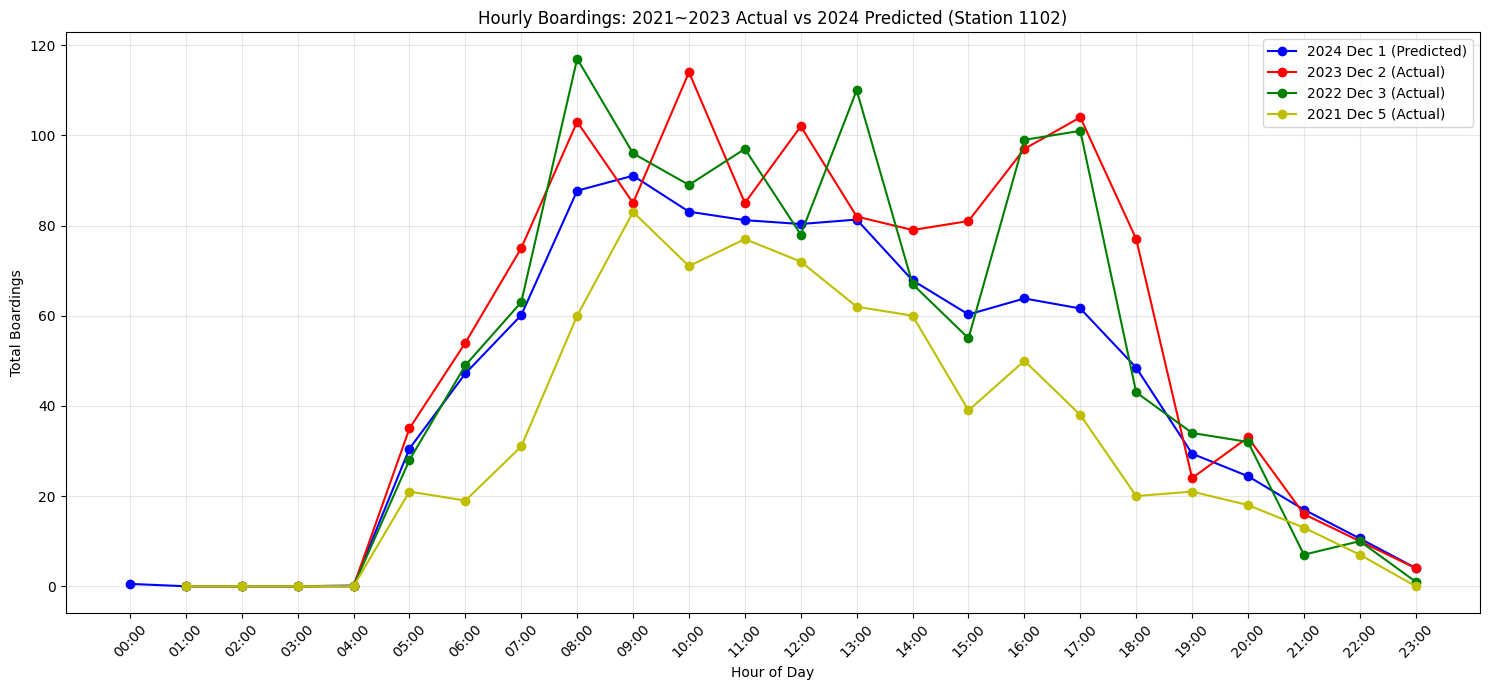

MAE: 14.67


In [ ]:


# 1. 데이터 로드
train = pd.read_csv('/content/final_boarding_weather_with_weekend_fix.csv')
train['BUSINESS_DAY'] = pd.to_datetime(train['BUSINESS_DAY'])

# 2. 주말 데이터 필터링
def filter_weekend_data(df, start_date, end_date):
    filtered = df[(df['BUSINESS_DAY'] >= start_date) &
                  (df['BUSINESS_DAY'] <= end_date) &
                  (df['IS_WEEKEND'] == 1) &
                  (df['STATION_NO'] == 1102)]
    return filtered

data_2021 = filter_weekend_data(train, '2021-09-01', '2021-12-05')
data_2022 = filter_weekend_data(train, '2022-09-01', '2022-12-03')
data_2023 = filter_weekend_data(train, '2023-09-01', '2023-12-03')

# 3. 시간대별 데이터 준비
def prepare_hourly_data(data):
    hourly_data = []
    for _, row in data.iterrows():
        date = row['BUSINESS_DAY']
        for hour in range(24):
            hour_col = f'CNT{hour:02d}'
            if hour_col in row:
                hourly_data.append({
                    'datetime': f"{date.strftime('%Y-%m-%d')} {hour:02d}:00:00",
                    'count': row[hour_col],
                    'hour': hour,
                    'sin_hour': np.sin(2 * np.pi * hour/24),
                    'cos_hour': np.cos(2 * np.pi * hour/24),
                    'rush_hour': 1 if (6 <= hour <= 9) or (17 <= hour <= 19) else 0
                })
    result = pd.DataFrame(hourly_data)
    result['datetime'] = pd.to_datetime(result['datetime'], format='%Y-%m-%d %H:%M:%S')
    return result

data_2021_hourly = prepare_hourly_data(data_2021)
data_2022_hourly = prepare_hourly_data(data_2022)
data_2023_hourly = prepare_hourly_data(data_2023)

# 4. 학습 데이터 병합
train_data = pd.concat([data_2021_hourly, data_2022_hourly, data_2023_hourly], ignore_index=True)

# 5. Random Forest 모델 학습
X = train_data[['hour', 'sin_hour', 'cos_hour', 'rush_hour']]
y = train_data['count']

# 샘플 가중치 생성
weights = np.ones(len(train_data))
weights[train_data['datetime'].dt.year == 2023] *= 1.5  # 2023년 데이터 가중치 1.5배

# 랜덤 포레스트 학습
rf_model = RandomForestRegressor(
    n_estimators=200,
    max_depth=10,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42
)
rf_model.fit(X, y, sample_weight=weights)


# 6. 24년 12월 1일 예측 데이터 생성
hours = list(range(24))
test_data = pd.DataFrame({
    'hour': hours,
    'sin_hour': np.sin(2 * np.pi * np.array(hours)/24),
    'cos_hour': np.cos(2 * np.pi * np.array(hours)/24),
    'rush_hour': [(1 if (6 <= h <= 9) or (17 <= h <= 19) else 0) for h in hours]
})

rf_predictions = rf_model.predict(test_data)

# 7. 실제 데이터 준비
actual_2023_dec2 = data_2023_hourly[data_2023_hourly['datetime'].dt.date == pd.Timestamp('2023-12-02').date()]
actual_2022_dec3 = data_2022_hourly[data_2022_hourly['datetime'].dt.date == pd.Timestamp('2022-12-03').date()]
actual_2021_dec1 = data_2021_hourly[data_2021_hourly['datetime'].dt.date == pd.Timestamp('2021-12-05').date()]

# 8. 시각화
plt.figure(figsize=(15, 7))
plt.plot(hours, rf_predictions, 'b-', label='2024 Dec 1 (Predicted)', marker='o')
plt.plot(actual_2023_dec2['hour'], actual_2023_dec2['count'], 'r-', label='2023 Dec 2 (Actual)', marker='o')
plt.plot(actual_2022_dec3['hour'], actual_2022_dec3['count'], 'g-', label='2022 Dec 3 (Actual)', marker='o')
plt.plot(actual_2021_dec1['hour'], actual_2021_dec1['count'], 'y-', label='2021 Dec 5 (Actual)', marker='o')

plt.title('Hourly Boardings: 2021~2023 Actual vs 2024 Predicted (Station 1102)')
plt.xlabel('Hour of Day')
plt.ylabel('Total Boardings')
plt.grid(True, alpha=0.3)
plt.legend()
plt.xticks(hours, [f'{h:02d}:00' for h in hours], rotation=45)
plt.tight_layout()
plt.show()

# 9. MAE 계산
min_length = min(len(actual_2023_dec2['count']), len(rf_predictions))
mae = mean_absolute_error(actual_2023_dec2['count'][:min_length], rf_predictions[:min_length])
print(f'MAE: {mae:.2f}')

In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error

# 1. 데이터 로드
train = pd.read_csv('/content/final_boarding_weather_with_weekend_fix.csv')
train['BUSINESS_DAY'] = pd.to_datetime(train['BUSINESS_DAY'])

# 2. 특성 생성 함수
def create_features(df):
    df = df.copy()
    df['hour'] = pd.to_datetime(df['datetime']).dt.hour
    df['sin_hour'] = np.sin(2 * np.pi * df['hour']/24)
    df['cos_hour'] = np.cos(2 * np.pi * df['hour']/24)
    df['rush_hour'] = ((df['hour'] >= 6) & (df['hour'] <= 9) |
                       (df['hour'] >= 17) & (df['hour'] <= 19)).astype(int)
    return df

# 3. 시간별 데이터 준비
def prepare_hourly_data(data):
    hourly_data = []
    for _, row in data.iterrows():
        date = row['BUSINESS_DAY']
        station = row['STATION_NO']
        for hour in range(24):
            hour_col = f'CNT{hour:02d}'
            if hour_col in row:
                hourly_data.append({
                    'datetime': f"{date.strftime('%Y-%m-%d')} {hour:02d}:00:00",
                    'count': row[hour_col],
                    'hour': hour,
                    'station': station
                })
    result = pd.DataFrame(hourly_data)
    result['datetime'] = pd.to_datetime(result['datetime'], format='%Y-%m-%d %H:%M:%S')
    return result

# 4. 주말 데이터 필터링 및 준비
weekend_data = train[train['IS_WEEKEND'] == 1]
train_data = prepare_hourly_data(weekend_data)
train_data = create_features(train_data)

# 5. 각 역별 예측
stations = sorted(train_data['station'].unique())
predictions_by_station = {}
mae_by_station = {}

for station in stations:
    # 해당 역의 데이터만 선택
    station_data = train_data[train_data['station'] == station]

    # 특성과 타겟 준비
    X = station_data[['hour', 'sin_hour', 'cos_hour', 'rush_hour']]
    y = station_data['count']

    # 모델 학습
    rf_model = RandomForestRegressor(n_estimators=200,
                                   max_depth=10,
                                   min_samples_split=5,
                                   min_samples_leaf=2,
                                   random_state=42)
    rf_model.fit(X, y)

    # 예측 데이터 준비
    hours = list(range(24))
    test_data = pd.DataFrame({
        'hour': hours,
        'datetime': pd.date_range('2024-12-01', periods=24, freq='h')
    })
    test_data = create_features(test_data)

    # 예측
    predictions = rf_model.predict(test_data[['hour', 'sin_hour', 'cos_hour', 'rush_hour']])
    predictions_by_station[station] = predictions

    # MAE 계산 - 수정된 부분
    station_hourly_mean = station_data.groupby('hour')['count'].mean().reindex(range(24)).fillna(0)
    mae = mean_absolute_error(station_hourly_mean, predictions)
    mae_by_station[station] = mae

# 6. 결과 시각화
colors = sns.color_palette("husl", n_colors=len(stations))
plt.figure(figsize=(15, 10))
for station in stations:
    plt.plot(range(24), predictions_by_station[station],
             label=f'Station {station}', marker='o')

plt.title('Hourly Boardings Prediction for All Stations (2024 Dec 1)')
plt.xlabel('Hour of Day')
plt.ylabel('Total Boardings')
plt.grid(True, alpha=0.3)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(range(24), [f'{h:02d}:00' for h in range(24)], rotation=45)
plt.tight_layout()
plt.show()

# 7. MAE 출력
for station in stations:
    print(f'Station {station} MAE: {mae_by_station[station]:.2f}')

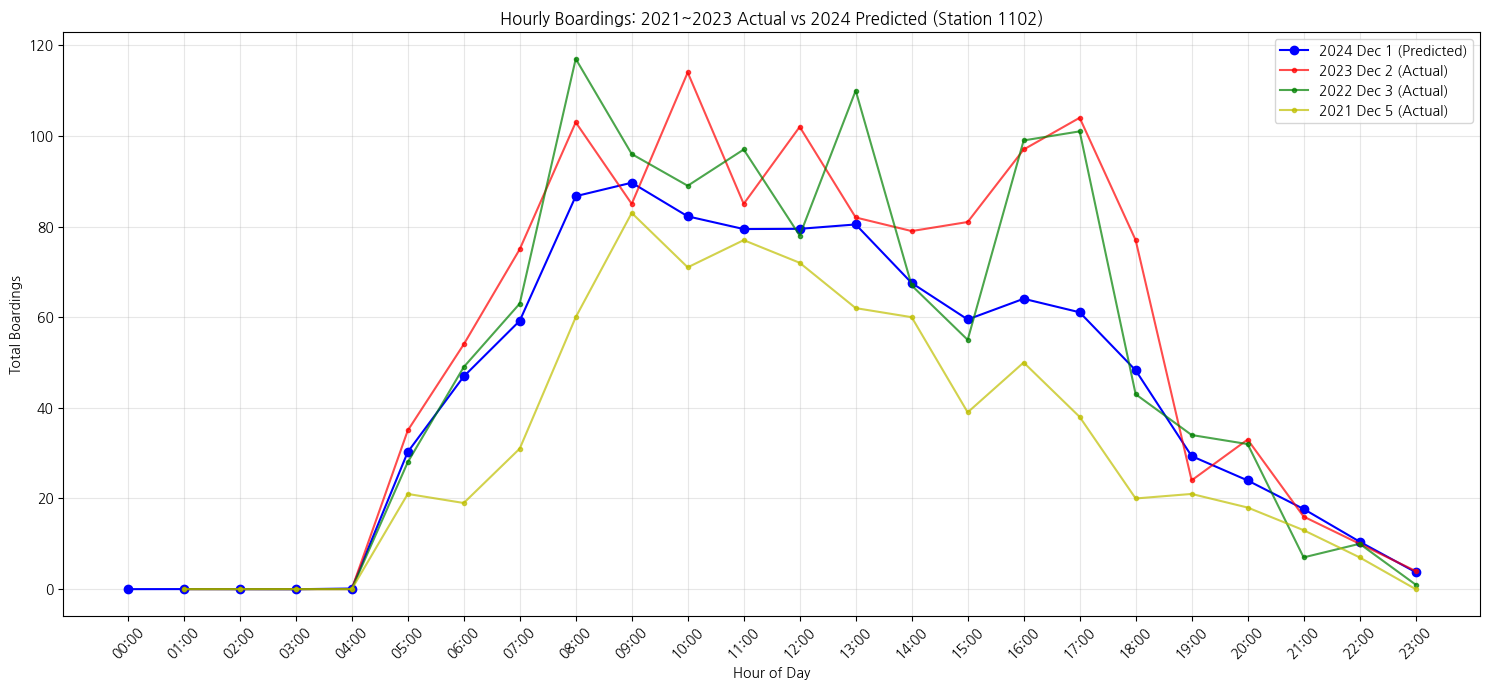

MAE: 14.90


In [ ]:
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error

# 1. 데이터 로드
train = pd.read_csv('/content/final_boarding_weather_with_weekend_fix.csv')
train['BUSINESS_DAY'] = pd.to_datetime(train['BUSINESS_DAY'])

# 2. 주말 데이터 필터링
def filter_weekend_data(df, start_date, end_date):
    filtered = df[(df['BUSINESS_DAY'] >= start_date) &
                  (df['BUSINESS_DAY'] <= end_date) &
                  (df['IS_WEEKEND'] == 1) &
                  (df['STATION_NO'] == 1102)]
    return filtered

data_2021 = filter_weekend_data(train, '2021-09-01', '2021-12-05')
data_2022 = filter_weekend_data(train, '2022-09-01', '2022-12-03')
data_2023 = filter_weekend_data(train, '2023-09-01', '2023-12-03')

# 3. 시간대별 데이터 준비
def prepare_hourly_data(data):
    hourly_data = []
    for _, row in data.iterrows():
        date = row['BUSINESS_DAY']
        for hour in range(24):
            hour_col = f'CNT{hour:02d}'
            if hour_col in row:
                hourly_data.append({
                    'datetime': f"{date.strftime('%Y-%m-%d')} {hour:02d}:00:00",
                    'count': row[hour_col],
                    'hour': hour,
                    'sin_hour': np.sin(2 * np.pi * hour/24),
                    'cos_hour': np.cos(2 * np.pi * hour/24),
                    'rush_hour': 1 if (6 <= hour <= 9) or (17 <= hour <= 19) else 0
                })
    result = pd.DataFrame(hourly_data)
    result['datetime'] = pd.to_datetime(result['datetime'], format='%Y-%m-%d %H:%M:%S')
    return result

data_2021_hourly = prepare_hourly_data(data_2021)
data_2022_hourly = prepare_hourly_data(data_2022)
data_2023_hourly = prepare_hourly_data(data_2023)

# 4. 학습 데이터 병합
train_data = pd.concat([data_2021_hourly, data_2022_hourly, data_2023_hourly], ignore_index=True)

# 5. XGBoost 모델 학습
X = train_data[['hour', 'sin_hour', 'cos_hour', 'rush_hour']]
y = train_data['count']

xgb_model = XGBRegressor(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=6,
    min_child_weight=1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)
xgb_model.fit(X, y)

# 6. 24년 12월 1일 예측 데이터 생성
hours = list(range(24))
test_data = pd.DataFrame({
    'hour': hours,
    'sin_hour': np.sin(2 * np.pi * np.array(hours)/24),
    'cos_hour': np.cos(2 * np.pi * np.array(hours)/24),
    'rush_hour': [(1 if (6 <= h <= 9) or (17 <= h <= 19) else 0) for h in hours]
})

xgb_predictions = xgb_model.predict(test_data)

# 7. 실제 데이터 준비
actual_2023_dec2 = data_2023_hourly[data_2023_hourly['datetime'].dt.date == pd.Timestamp('2023-12-02').date()]
actual_2022_dec3 = data_2022_hourly[data_2022_hourly['datetime'].dt.date == pd.Timestamp('2022-12-03').date()]
actual_2021_dec1 = data_2021_hourly[data_2021_hourly['datetime'].dt.date == pd.Timestamp('2021-12-05').date()]

# 8. 시각화
plt.figure(figsize=(15, 7))
plt.plot(hours, xgb_predictions, 'b-', label='2024 Dec 1 (Predicted)', marker='o')
plt.plot(actual_2023_dec2['hour'], actual_2023_dec2['count'], 'r-', label='2023 Dec 2 (Actual)', marker='.', alpha = 0.7)
plt.plot(actual_2022_dec3['hour'], actual_2022_dec3['count'], 'g-', label='2022 Dec 3 (Actual)', marker='.', alpha = 0.7)
plt.plot(actual_2021_dec1['hour'], actual_2021_dec1['count'], 'y-', label='2021 Dec 5 (Actual)', marker='.', alpha = 0.7)

plt.title('Hourly Boardings: 2021~2023 Actual vs 2024 Predicted (Station 1102)')
plt.xlabel('Hour of Day')
plt.ylabel('Total Boardings')
plt.grid(True, alpha=0.3)
plt.legend()
plt.xticks(hours, [f'{h:02d}:00' for h in hours], rotation=45)
plt.tight_layout()
plt.show()

# 9. MAE 계산
min_length = min(len(actual_2023_dec2['count']), len(xgb_predictions))
mae = mean_absolute_error(actual_2023_dec2['count'][:min_length], xgb_predictions[:min_length])
print(f'MAE: {mae:.2f}')

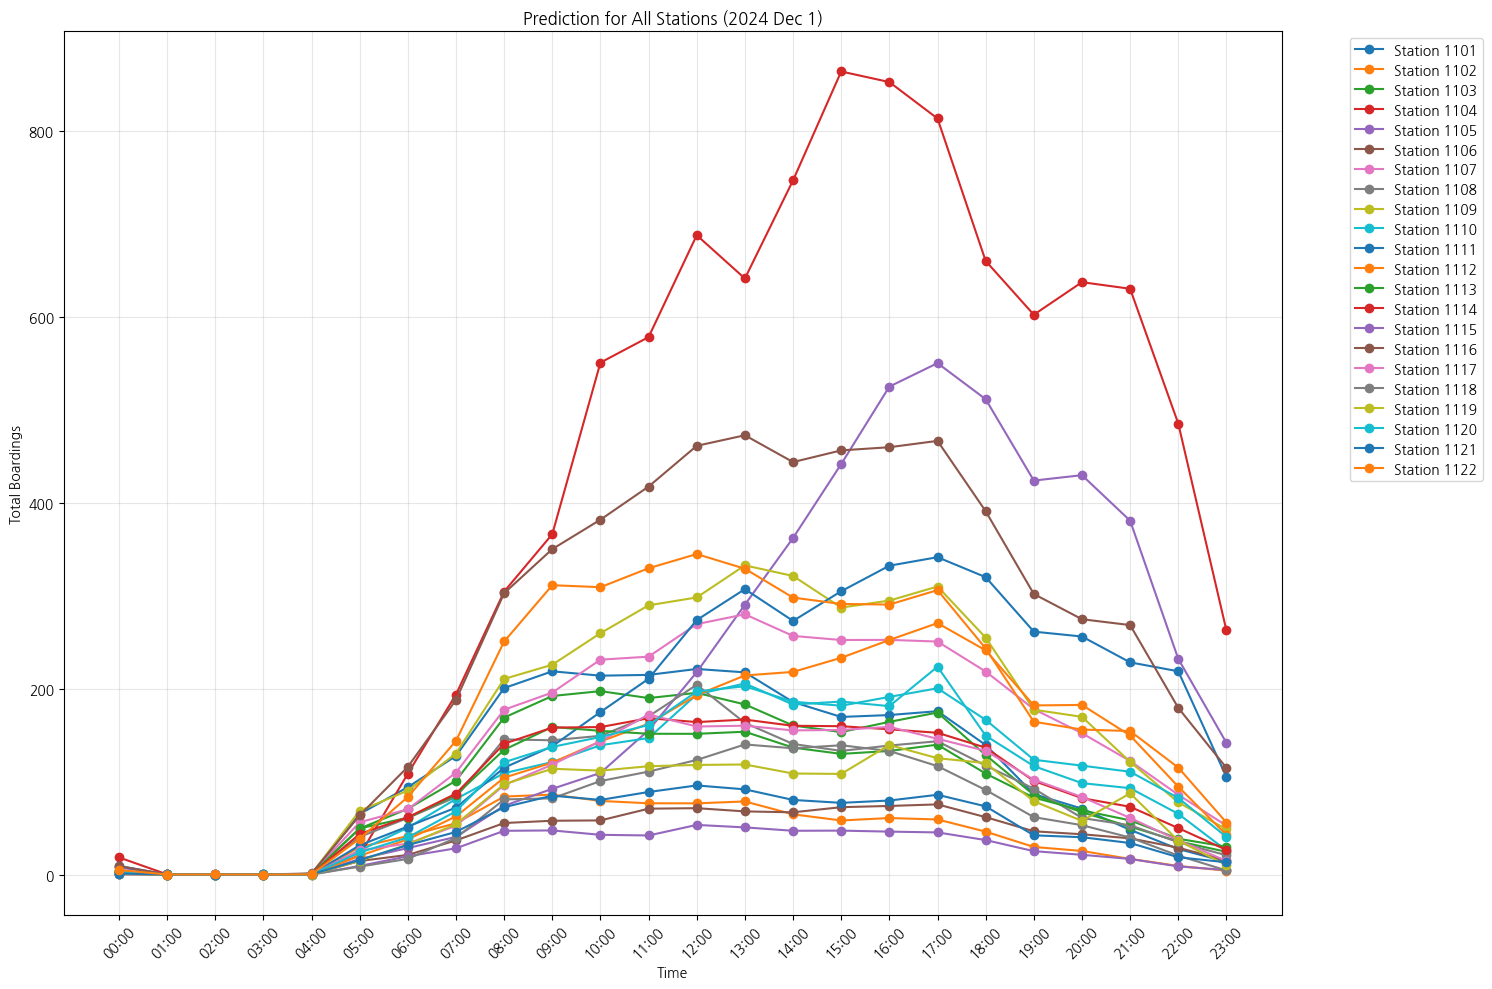

Station 1101 MAE: 0.20
Station 1102 MAE: 0.10
Station 1103 MAE: 0.25
Station 1104 MAE: 1.37
Station 1105 MAE: 0.73
Station 1106 MAE: 0.12
Station 1107 MAE: 0.47
Station 1108 MAE: 0.21
Station 1109 MAE: 0.44
Station 1110 MAE: 0.22
Station 1111 MAE: 0.60
Station 1112 MAE: 0.31
Station 1113 MAE: 0.22
Station 1114 MAE: 0.24
Station 1115 MAE: 0.06
Station 1116 MAE: 0.70
Station 1117 MAE: 0.21
Station 1118 MAE: 0.09
Station 1119 MAE: 0.35
Station 1120 MAE: 0.26
Station 1121 MAE: 0.10
Station 1122 MAE: 0.41


In [ ]:
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error

# 1. 데이터 로드
train = pd.read_csv('/content/final_boarding_weather_with_weekend_fix.csv')
train['BUSINESS_DAY'] = pd.to_datetime(train['BUSINESS_DAY'])

# 2. 특성 생성 함수
def create_features(df):
    df = df.copy()
    df['hour'] = pd.to_datetime(df['datetime']).dt.hour
    df['sin_hour'] = np.sin(2 * np.pi * df['hour']/24)
    df['cos_hour'] = np.cos(2 * np.pi * df['hour']/24)
    df['rush_hour'] = ((df['hour'] >= 6) & (df['hour'] <= 9) |
                       (df['hour'] >= 17) & (df['hour'] <= 19)).astype(int)
    return df

# 3. 시간별 데이터 준비
def prepare_hourly_data(data):
    hourly_data = []
    for _, row in data.iterrows():
        date = row['BUSINESS_DAY']
        station = row['STATION_NO']
        for hour in range(24):
            hour_col = f'CNT{hour:02d}'
            if hour_col in row:
                hourly_data.append({
                    'datetime': f"{date.strftime('%Y-%m-%d')} {hour:02d}:00:00",
                    'count': row[hour_col],
                    'hour': hour,
                    'station': station
                })
    result = pd.DataFrame(hourly_data)
    result['datetime'] = pd.to_datetime(result['datetime'], format='%Y-%m-%d %H:%M:%S')
    return result

# 4. 주말 데이터 필터링 및 준비
weekend_data = train[train['IS_WEEKEND'] == 1]
train_data = prepare_hourly_data(weekend_data)
train_data = create_features(train_data)

# 5. 각 역별 예측
stations = sorted(train_data['station'].unique())
predictions_by_station = {}
mae_by_station = {}

for station in stations:
    # 해당 역의 데이터만 선택
    station_data = train_data[train_data['station'] == station]

    # 특성과 타겟 준비
    X = station_data[['hour', 'sin_hour', 'cos_hour', 'rush_hour']]
    y = station_data['count']

    # XGBoost 모델 학습
    xgb_model = XGBRegressor(
        n_estimators=200,
        learning_rate=0.1,
        max_depth=6,
        min_child_weight=1,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42
    )
    xgb_model.fit(X, y)

    # 예측 데이터 준비
    hours = list(range(24))
    test_data = pd.DataFrame({
        'hour': hours,
        'datetime': pd.date_range('2024-12-01', periods=24, freq='h')
    })
    test_data = create_features(test_data)

    # 예측
    predictions = xgb_model.predict(test_data[['hour', 'sin_hour', 'cos_hour', 'rush_hour']])
    predictions_by_station[station] = predictions

    # MAE 계산
    station_hourly_mean = station_data.groupby('hour')['count'].mean().reindex(range(24)).fillna(0)
    mae = mean_absolute_error(station_hourly_mean, predictions)
    mae_by_station[station] = mae

# 6. 결과 시각화
plt.figure(figsize=(15, 10))
for station in stations:
    plt.plot(range(24), predictions_by_station[station],
             label=f'Station {station}', marker='o')

plt.title('Prediction for All Stations (2024 Dec 1)')
plt.xlabel('Time')
plt.ylabel('Total Boardings')
plt.grid(True, alpha=0.3)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(range(24), [f'{h:02d}:00' for h in range(24)], rotation=45)
plt.tight_layout()
plt.show()

# 7. MAE 출력
for station in stations:
    print(f'Station {station} MAE: {mae_by_station[station]:.2f}')

---

# 장운혁


## 역 이름 반영

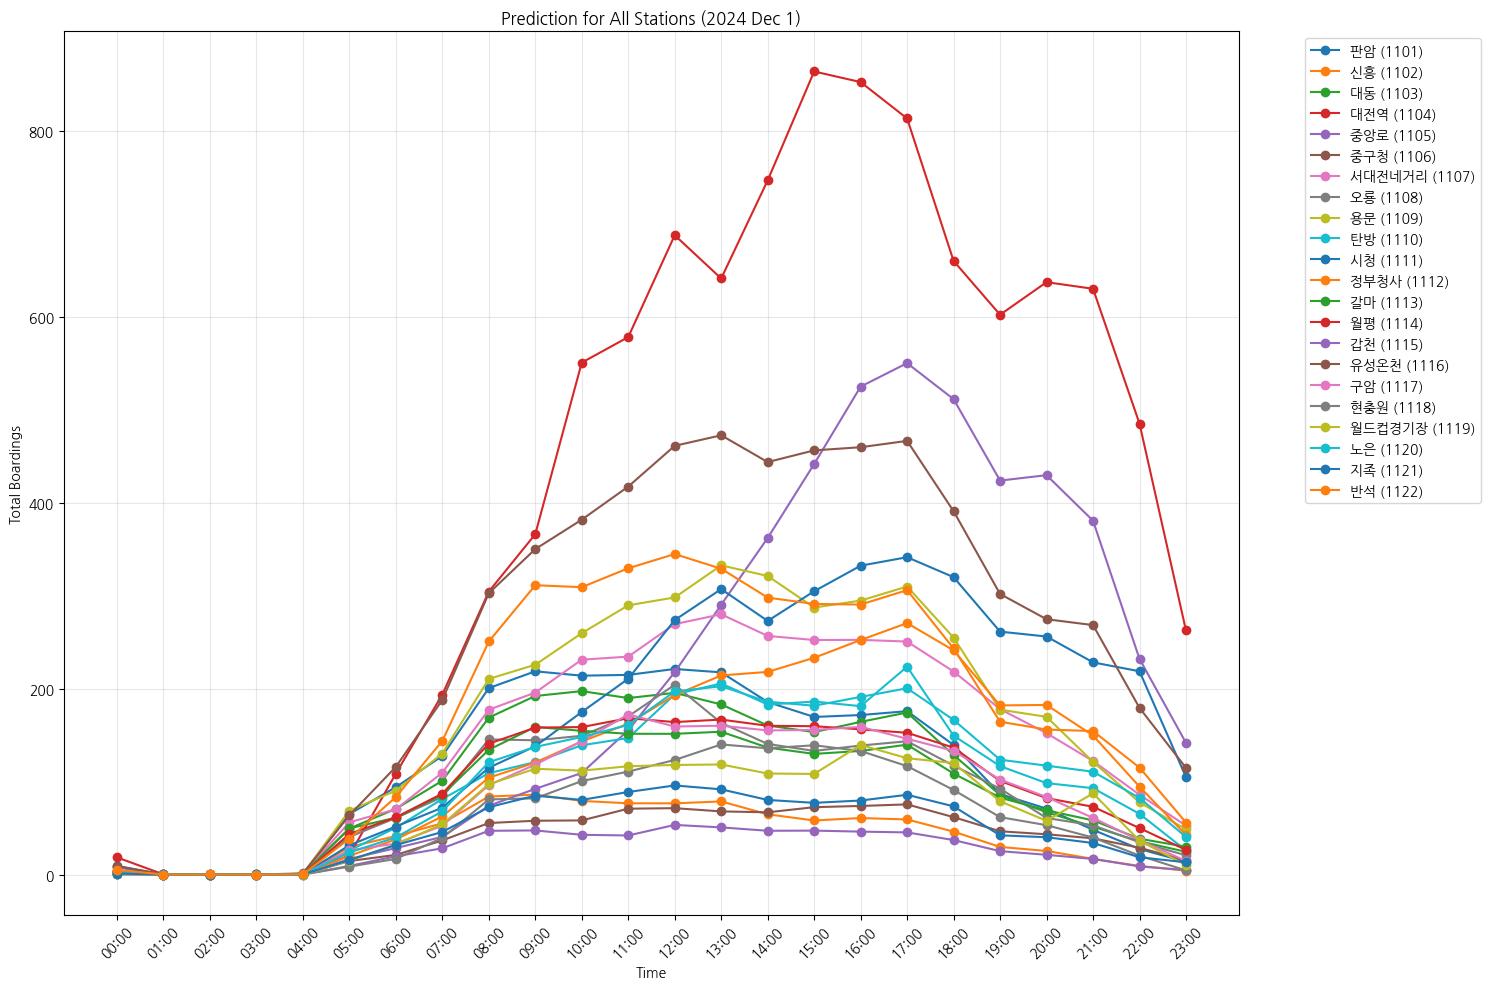

판암 (1101) MAE: 0.20
신흥 (1102) MAE: 0.10
대동 (1103) MAE: 0.25
대전역 (1104) MAE: 1.37
중앙로 (1105) MAE: 0.73
중구청 (1106) MAE: 0.12
서대전네거리 (1107) MAE: 0.47
오룡 (1108) MAE: 0.21
용문 (1109) MAE: 0.44
탄방 (1110) MAE: 0.22
시청 (1111) MAE: 0.60
정부청사 (1112) MAE: 0.31
갈마 (1113) MAE: 0.22
월평 (1114) MAE: 0.24
갑천 (1115) MAE: 0.06
유성온천 (1116) MAE: 0.70
구암 (1117) MAE: 0.21
현충원 (1118) MAE: 0.09
월드컵경기장 (1119) MAE: 0.35
노은 (1120) MAE: 0.26
지족 (1121) MAE: 0.10
반석 (1122) MAE: 0.41


In [ ]:
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error

!pip install koreanize-matplotlib
import koreanize_matplotlib

# 1. 데이터 로드
train = pd.read_csv('final_boarding_weather_with_weekend_fix.csv')
train['BUSINESS_DAY'] = pd.to_datetime(train['BUSINESS_DAY'])

# 2. 특성 생성 함수
def create_features(df):
    df = df.copy()
    df['hour'] = pd.to_datetime(df['datetime']).dt.hour
    df['sin_hour'] = np.sin(2 * np.pi * df['hour']/24)
    df['cos_hour'] = np.cos(2 * np.pi * df['hour']/24)
    df['rush_hour'] = ((df['hour'] >= 6) & (df['hour'] <= 9) |
                       (df['hour'] >= 17) & (df['hour'] <= 19)).astype(int)
    return df

# 3. 시간별 데이터 준비
def prepare_hourly_data(data):
    hourly_data = []
    for _, row in data.iterrows():
        date = row['BUSINESS_DAY']
        station = row['STATION_NO']
        for hour in range(24):
            hour_col = f'CNT{hour:02d}'
            if hour_col in row:
                hourly_data.append({
                    'datetime': f"{date.strftime('%Y-%m-%d')} {hour:02d}:00:00",
                    'count': row[hour_col],
                    'hour': hour,
                    'station': station
                })
    result = pd.DataFrame(hourly_data)
    result['datetime'] = pd.to_datetime(result['datetime'], format='%Y-%m-%d %H:%M:%S')
    return result

station_names = {
    1101: '판암',
    1102: '신흥',
    1103: '대동',
    1104: '대전역',
    1105: '중앙로',
    1106: '중구청',
    1107: '서대전네거리',
    1108: '오룡',
    1109: '용문',
    1110: '탄방',
    1111: '시청',
    1112: '정부청사',
    1113: '갈마',
    1114: '월평',
    1115: '갑천',
    1116: '유성온천',
    1117: '구암',
    1118: '현충원',
    1119: '월드컵경기장',
    1120: '노은',
    1121: '지족',
    1122: '반석'
}


# 4. 주말 데이터 필터링 및 준비
weekend_data = train[train['IS_WEEKEND'] == 1]
train_data = prepare_hourly_data(weekend_data)
train_data = create_features(train_data)

# 5. 각 역별 예측
stations = sorted(train_data['station'].unique())
predictions_by_station = {}
mae_by_station = {}

for station in stations:
    # 해당 역의 데이터만 선택
    station_data = train_data[train_data['station'] == station]

    # 특성과 타겟 준비
    X = station_data[['hour', 'sin_hour', 'cos_hour', 'rush_hour']]
    y = station_data['count']

    # XGBoost 모델 학습
    xgb_model = XGBRegressor(
        n_estimators=200,
        learning_rate=0.1,
        max_depth=6,
        min_child_weight=1,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42
    )
    xgb_model.fit(X, y)

    # 예측 데이터 준비
    hours = list(range(24))
    test_data = pd.DataFrame({
        'hour': hours,
        'datetime': pd.date_range('2024-12-01', periods=24, freq='h')
    })
    test_data = create_features(test_data)

    # 예측
    predictions = xgb_model.predict(test_data[['hour', 'sin_hour', 'cos_hour', 'rush_hour']])
    predictions_by_station[station] = predictions

    # MAE 계산
    station_hourly_mean = station_data.groupby('hour')['count'].mean().reindex(range(24)).fillna(0)
    mae = mean_absolute_error(station_hourly_mean, predictions)
    mae_by_station[station] = mae

# 플롯 생성 부분 수정
plt.figure(figsize=(15, 10))
for station in stations:
    plt.plot(range(24), predictions_by_station[station],
             label=f'{station_names[station]} ({station})', marker='o')

plt.title('Prediction for All Stations (2024 Dec 1)')
plt.xlabel('Time')
plt.ylabel('Total Boardings')
plt.grid(True, alpha=0.3)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(range(24), [f'{h:02d}:00' for h in range(24)], rotation=45)
plt.tight_layout()
plt.show()

# MAE 출력 부분도 수정
for station in stations:
    print(f'{station_names[station]} ({station}) MAE: {mae_by_station[station]:.2f}')

## 2021년 제외

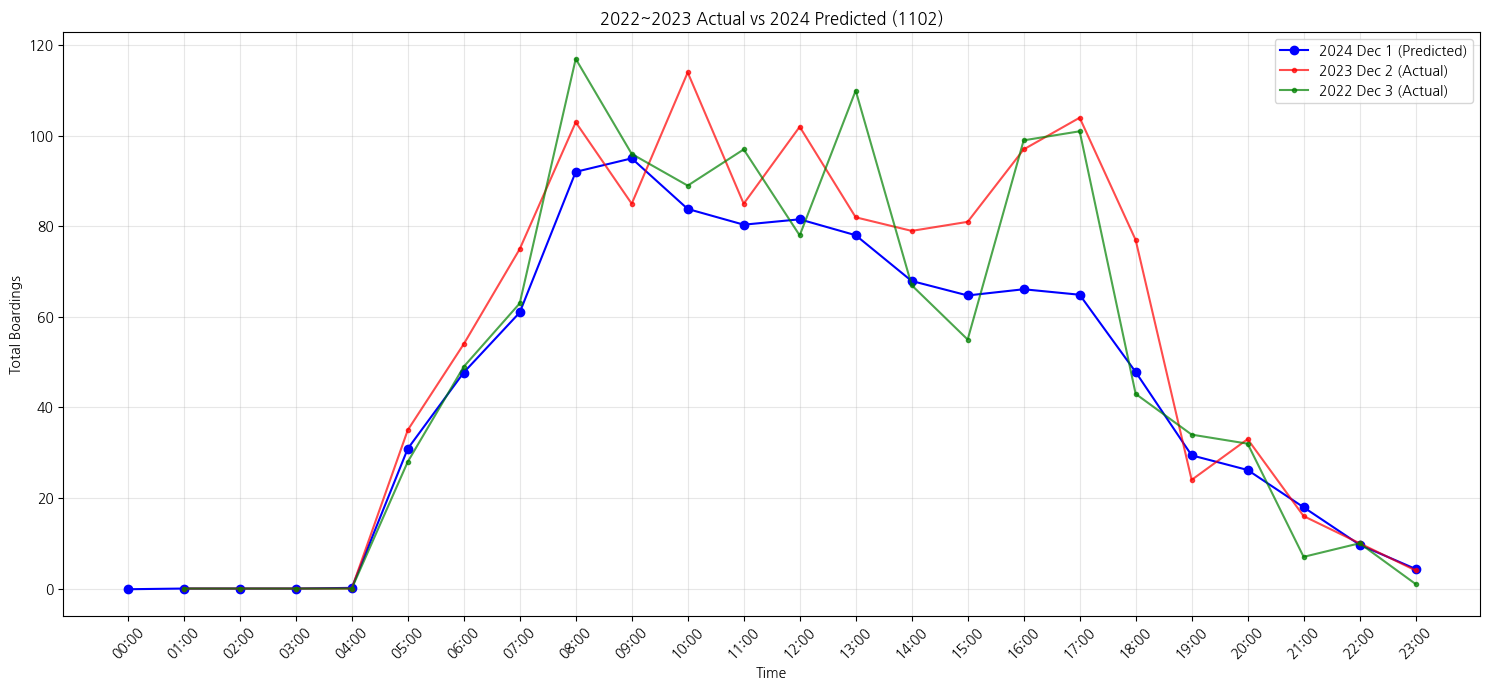

MAE: 14.09


In [ ]:
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error

# 1. 데이터 로드
train = pd.read_csv('/content/final_boarding_weather_with_weekend_fix.csv')
train['BUSINESS_DAY'] = pd.to_datetime(train['BUSINESS_DAY'])

# 2. 주말 데이터 필터링
def filter_weekend_data(df, start_date, end_date):
    filtered = df[(df['BUSINESS_DAY'] >= start_date) &
                  (df['BUSINESS_DAY'] <= end_date) &
                  (df['IS_WEEKEND'] == 1) &
                  (df['STATION_NO'] == 1102)]
    return filtered

# 2021년 데이터 제외
data_2022 = filter_weekend_data(train, '2022-09-01', '2022-12-03')
data_2023 = filter_weekend_data(train, '2023-09-01', '2023-12-03')

# 3. 시간대별 데이터 준비
def prepare_hourly_data(data):
    hourly_data = []
    for _, row in data.iterrows():
        date = row['BUSINESS_DAY']
        for hour in range(24):
            hour_col = f'CNT{hour:02d}'
            if hour_col in row:
                hourly_data.append({
                    'datetime': f"{date.strftime('%Y-%m-%d')} {hour:02d}:00:00",
                    'count': row[hour_col],
                    'hour': hour,
                    'sin_hour': np.sin(2 * np.pi * hour/24),
                    'cos_hour': np.cos(2 * np.pi * hour/24),
                    'rush_hour': 1 if (6 <= hour <= 9) or (17 <= hour <= 19) else 0
                })
    result = pd.DataFrame(hourly_data)
    result['datetime'] = pd.to_datetime(result['datetime'], format='%Y-%m-%d %H:%M:%S')
    return result

data_2022_hourly = prepare_hourly_data(data_2022)
data_2023_hourly = prepare_hourly_data(data_2023)

# 4. 학습 데이터 병합 (2022, 2023년만)
train_data = pd.concat([data_2022_hourly, data_2023_hourly], ignore_index=True)

# 5. XGBoost 모델 학습
X = train_data[['hour', 'sin_hour', 'cos_hour', 'rush_hour']]
y = train_data['count']

xgb_model = XGBRegressor(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=50,
    min_child_weight=0.1,
    subsample=0.1,
    colsample_bytree=0.8,
    random_state=42
)
xgb_model.fit(X, y)

# 6. 24년 12월 1일 예측 데이터 생성
hours = list(range(24))
test_data = pd.DataFrame({
    'hour': hours,
    'sin_hour': np.sin(2 * np.pi * np.array(hours)/24),
    'cos_hour': np.cos(2 * np.pi * np.array(hours)/24),
    'rush_hour': [(1 if (6 <= h <= 9) or (17 <= h <= 19) else 0) for h in hours]
})

xgb_predictions = xgb_model.predict(test_data)

# 7. 실제 데이터 준비 (2022, 2023년만)
actual_2023_dec2 = data_2023_hourly[data_2023_hourly['datetime'].dt.date == pd.Timestamp('2023-12-02').date()]
actual_2022_dec3 = data_2022_hourly[data_2022_hourly['datetime'].dt.date == pd.Timestamp('2022-12-03').date()]

# 8. 시각화
plt.figure(figsize=(15, 7))
plt.plot(hours, xgb_predictions, 'b-', label='2024 Dec 1 (Predicted)', marker='o')
plt.plot(actual_2023_dec2['hour'], actual_2023_dec2['count'], 'r-', label='2023 Dec 2 (Actual)', marker='.', alpha=0.7)
plt.plot(actual_2022_dec3['hour'], actual_2022_dec3['count'], 'g-', label='2022 Dec 3 (Actual)', marker='.', alpha=0.7)

plt.title('2022~2023 Actual vs 2024 Predicted (1102)')
plt.xlabel('Time')
plt.ylabel('Total Boardings')
plt.grid(True, alpha=0.3)
plt.legend()
plt.xticks(hours, [f'{h:02d}:00' for h in hours], rotation=45)
plt.tight_layout()
plt.show()

# 9. MAE 계산
min_length = min(len(actual_2023_dec2['count']), len(xgb_predictions))
mae = mean_absolute_error(actual_2023_dec2['count'][:min_length], xgb_predictions[:min_length])
print(f'MAE: {mae:.2f}')


/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Best Parameters: {'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 200}
Feature Importances:
         Feature  Importance
2       cos_hour    0.898411
0           hour    0.047512
1       sin_hour    0.024269
6           평균기온    0.007500
7           최저기온    0.005937
8           최고기온    0.005634
4  rainfall_flag    0.005555
5     is_holiday    0.005176
3      rush_hour    0.000005


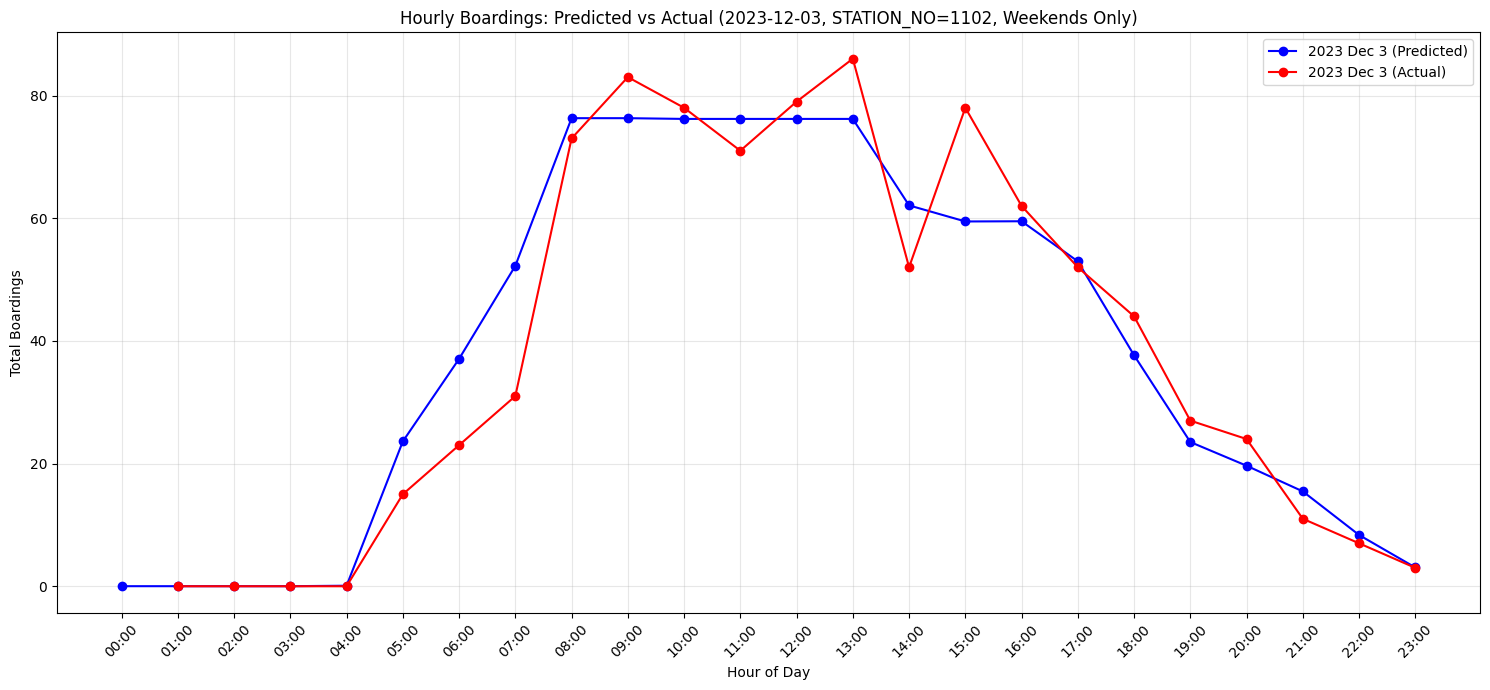

MAE: 7.01


In [ ]:
# 1. 데이터 로드
train = pd.read_csv('updated_file.csv')
train['날짜'] = pd.to_datetime(train['날짜'])

# 2. 특정 STATION_NO 및 주말 필터링
train = train[(train['STATION_NO'] == 1102) & (train['IS_WEEKEND'] == 1)]

# 3. 학습 데이터 필터링
def filter_training_data(df, start_date, end_date):
    return df[(df['날짜'] >= start_date) & (df['날짜'] <= end_date)]

data_2021 = filter_training_data(train, '2021-01-01', '2021-12-10')
data_2022 = filter_training_data(train, '2022-01-01', '2022-12-10')

# 4. 강수량 여부 변수 추가
train['rainfall_flag'] = (train['강수량(mm)'] > 0).astype(int)

# 5. 시간대별 데이터 준비 (기온 추가)
def prepare_hourly_data(data):
    hourly_data = []
    for _, row in data.iterrows():
        date = row['날짜']
        for hour in range(24):
            hour_col = f'CNT{hour:02d}'
            if hour_col in row:
                hourly_data.append({
                    'datetime': f"{date.strftime('%Y-%m-%d')} {hour:02d}:00:00",
                    'hour': hour,
                    'count': row[hour_col],
                    'sin_hour': np.sin(2 * np.pi * hour / 24),
                    'cos_hour': np.cos(2 * np.pi * hour / 24),
                    'rush_hour': 1 if (6 <= hour <= 9) or (17 <= hour <= 19) else 0,
                    'rainfall_flag': row['강수량(mm)'],
                    'is_holiday': row['IS_HOLIDAY'],
                    '평균기온': row['평균기온(℃)'],
                    '최저기온': row['최저기온(℃)'],
                    '최고기온': row['최고기온(℃)']
                })
    result = pd.DataFrame(hourly_data)
    result['datetime'] = pd.to_datetime(result['datetime'], format='%Y-%m-%d %H:%M:%S')
    return result

data_2021_hourly = prepare_hourly_data(data_2021)
data_2022_hourly = prepare_hourly_data(data_2022)

# 6. 학습 데이터 병합
train_data = pd.concat([data_2021_hourly, data_2022_hourly], ignore_index=True)

# 7. 데이터 정규화
scaler = StandardScaler()
features = ['hour', 'sin_hour', 'cos_hour', 'rush_hour', 'rainfall_flag', 'is_holiday',
            '평균기온', '최저기온', '최고기온']
train_data[features] = scaler.fit_transform(train_data[features])

# 8. Random Forest 모델 학습
X = train_data[features]
y = train_data['count']

# 교차 검증 및 하이퍼파라미터 튜닝
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
grid_search = GridSearchCV(RandomForestRegressor(random_state=42), param_grid, cv=3, scoring='neg_mean_absolute_error')
grid_search.fit(X, y)
print("Best Parameters:", grid_search.best_params_)

rf_model = grid_search.best_estimator_

# 변수 중요도 확인
feature_importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf_model.feature_importances_
}).sort_values(by='Importance', ascending=False)
print("Feature Importances:")
print(feature_importances)

# 9. 2023년 12월 3일 예측 데이터 생성
hours = list(range(24))
test_data = pd.DataFrame({
    'hour': hours,
    'sin_hour': np.sin(2 * np.pi * np.array(hours) / 24),
    'cos_hour': np.cos(2 * np.pi * np.array(hours) / 24),
    'rush_hour': [(1 if (6 <= h <= 9) or (17 <= h <= 19) else 0) for h in hours],
    'rainfall_flag': train[train['날짜'] == '2023-12-03']['rainfall_flag'].iloc[0],
    'is_holiday': train[train['날짜'] == '2023-12-03']['IS_HOLIDAY'].iloc[0],
    '평균기온': train[train['날짜'] == '2023-12-03']['평균기온(℃)'].iloc[0],
    '최저기온': train[train['날짜'] == '2023-12-03']['최저기온(℃)'].iloc[0],
    '최고기온': train[train['날짜'] == '2023-12-03']['최고기온(℃)'].iloc[0]
})
test_data[features] = scaler.transform(test_data[features])  # 정규화 적용

rf_predictions = rf_model.predict(test_data)

# 10. 2023년 12월 3일 실제 데이터 준비
data_2023 = filter_training_data(train, '2023-12-03', '2023-12-03')
data_2023_hourly = prepare_hourly_data(data_2023)

# 11. 시각화
plt.figure(figsize=(15, 7))
plt.plot(hours, rf_predictions, 'b-', label='2023 Dec 3 (Predicted)', marker='o')
plt.plot(data_2023_hourly['hour'], data_2023_hourly['count'], 'r-', label='2023 Dec 3 (Actual)', marker='o')

plt.title('Hourly Boardings: Predicted vs Actual (2023-12-03, STATION_NO=1102, Weekends Only)')
plt.xlabel('Hour of Day')
plt.ylabel('Total Boardings')
plt.grid(True, alpha=0.3)
plt.legend()
plt.xticks(hours, [f'{h:02d}:00' for h in hours], rotation=45)
plt.tight_layout()
plt.show()

# 12. MAE 계산
min_length = min(len(data_2023_hourly['count']), len(rf_predictions))
mae = mean_absolute_error(data_2023_hourly['count'][:min_length], rf_predictions[:min_length])
print(f"MAE: {mae:.2f}")

Best Parameters: {'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}


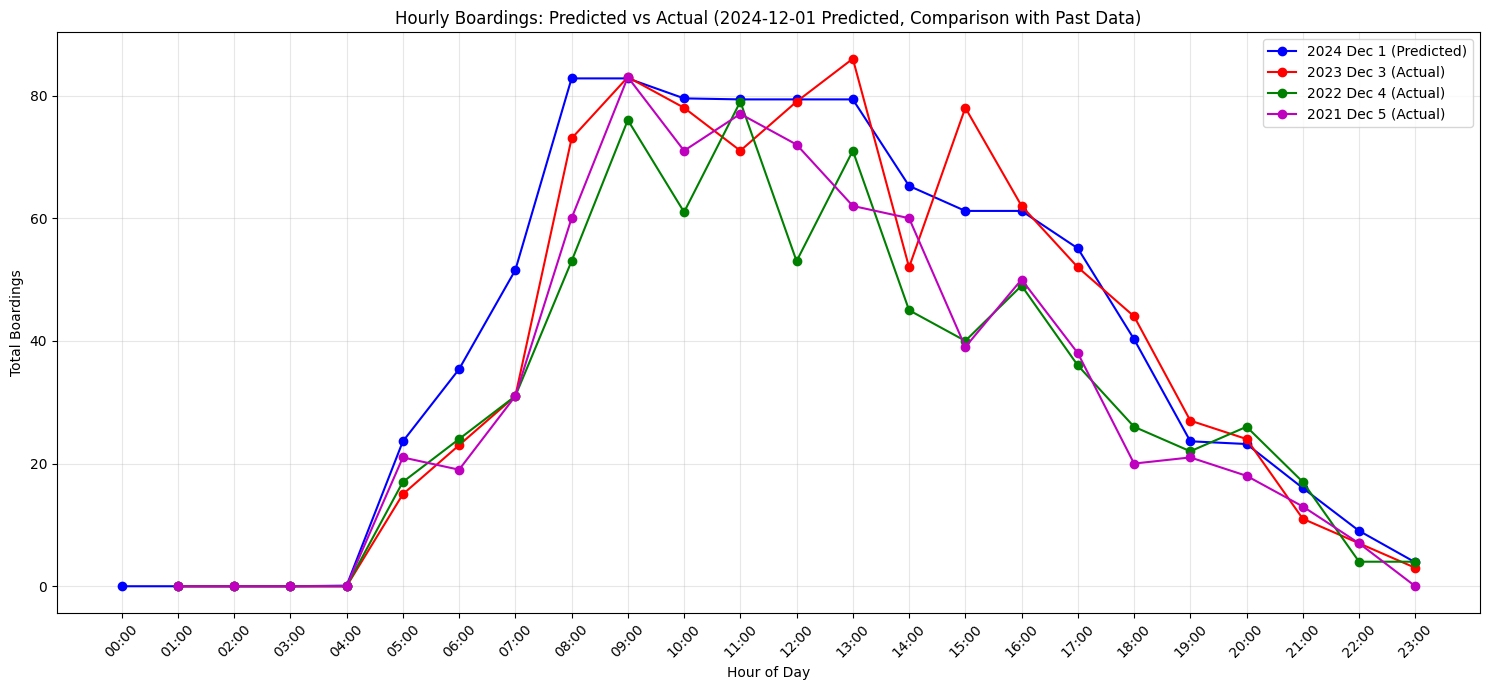

MAE (2024 Prediction vs 2023 Actual): 7.13


In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import cross_val_score, GridSearchCV
import matplotlib.pyplot as plt

# 1. 데이터 로드
train = pd.read_csv('/content/updated_file.csv')
train['날짜'] = pd.to_datetime(train['날짜'])

# 2. 특정 STATION_NO 및 주말 필터링
train = train[(train['STATION_NO'] == 1102) & (train['IS_WEEKEND'] == 1)]

# 3. 학습 데이터 필터링
def filter_training_data(df, start_date, end_date):
    return df[(df['날짜'] >= start_date) & (df['날짜'] <= end_date)]

data_2021 = filter_training_data(train, '2021-01-01', '2021-12-31')
data_2022 = filter_training_data(train, '2022-01-01', '2022-12-31')
data_2023 = filter_training_data(train, '2023-01-01', '2023-12-31')

# 4. 강수량 여부 변수 추가
train['rainfall_flag'] = (train['강수량(mm)'] > 0).astype(int)

# 5. 시간대별 데이터 준비
def prepare_hourly_data(data):
    hourly_data = []
    for _, row in data.iterrows():
        date = row['날짜']
        for hour in range(24):
            hour_col = f'CNT{hour:02d}'
            if hour_col in row:
                hourly_data.append({
                    'datetime': f"{date.strftime('%Y-%m-%d')} {hour:02d}:00:00",
                    'hour': hour,
                    'count': row[hour_col],
                    'sin_hour': np.sin(2 * np.pi * hour / 24),
                    'cos_hour': np.cos(2 * np.pi * hour / 24),
                    'rush_hour': 1 if (6 <= hour <= 9) or (17 <= hour <= 19) else 0,
                    'rainfall_flag': row['강수량(mm)'],
                    'is_holiday': row['IS_HOLIDAY'],
                    '평균기온': row['평균기온(℃)'],
                    '최저기온': row['최저기온(℃)'],
                    '최고기온': row['최고기온(℃)']
                })
    result = pd.DataFrame(hourly_data)
    result['datetime'] = pd.to_datetime(result['datetime'], format='%Y-%m-%d %H:%M:%S')
    return result

data_2021_hourly = prepare_hourly_data(data_2021)
data_2022_hourly = prepare_hourly_data(data_2022)
data_2023_hourly = prepare_hourly_data(data_2023)


# 6. 학습 데이터 병합
train_data = pd.concat([data_2021_hourly, data_2022_hourly, data_2023_hourly], ignore_index=True)

# 7. 데이터 정규화
scaler = StandardScaler()
features = ['hour', 'sin_hour', 'cos_hour', 'rush_hour', 'rainfall_flag', 'is_holiday',
            '평균기온', '최저기온', '최고기온']
train_data[features] = scaler.fit_transform(train_data[features])

# 8. Random Forest 모델 학습
X = train_data[features]
y = train_data['count']

# 교차 검증 및 하이퍼파라미터 튜닝
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
grid_search = GridSearchCV(RandomForestRegressor(random_state=42), param_grid, cv=3, scoring='neg_mean_absolute_error')
grid_search.fit(X, y)
print("Best Parameters:", grid_search.best_params_)

rf_model = grid_search.best_estimator_

# 9. 2024년 12월 1일 예측 데이터 생성
hours = list(range(24))
test_data_2024 = pd.DataFrame({
    'hour': hours,
    'sin_hour': np.sin(2 * np.pi * np.array(hours) / 24),
    'cos_hour': np.cos(2 * np.pi * np.array(hours) / 24),
    'rush_hour': [(1 if (6 <= h <= 9) or (17 <= h <= 19) else 0) for h in hours],
    'rainfall_flag': 0,  # 임의 데이터 (강수량 없음으로 가정)
    'is_holiday': 0,  # 임의 데이터 (공휴일 아님으로 가정)
    '평균기온': 5,  # 임의 데이터 (평균 기온 추정치)
    '최저기온': 4,  # 임의 데이터
    '최고기온': 12  # 임의 데이터
})
test_data_2024[features] = scaler.transform(test_data_2024[features])  # 정규화 적용

rf_predictions_2024 = rf_model.predict(test_data_2024)

# 10. 시각화 (2024년 12월 1일 예측값)
plt.figure(figsize=(15, 7))
plt.plot(hours, rf_predictions_2024, 'b-', label='2024 Dec 1 (Predicted)', marker='o')

# 비교: 2023년 12월 3일, 2022년 12월 4일, 2021년 12월 5일 실제 데이터
data_2023_actual = prepare_hourly_data(filter_training_data(train, '2023-12-03', '2023-12-03'))
data_2022_actual = prepare_hourly_data(filter_training_data(train, '2022-12-04', '2022-12-04'))
data_2021_actual = prepare_hourly_data(filter_training_data(train, '2021-12-05', '2021-12-05'))

plt.plot(data_2023_actual['hour'], data_2023_actual['count'], 'r-', label='2023 Dec 3 (Actual)', marker='o')
plt.plot(data_2022_actual['hour'], data_2022_actual['count'], 'g-', label='2022 Dec 4 (Actual)', marker='o')
plt.plot(data_2021_actual['hour'], data_2021_actual['count'], 'm-', label='2021 Dec 5 (Actual)', marker='o')

plt.title('Hourly Boardings: Predicted vs Actual (2024-12-01 Predicted, Comparison with Past Data)')
plt.xlabel('Hour of Day')
plt.ylabel('Total Boardings')
plt.grid(True, alpha=0.3)
plt.legend()
plt.xticks(hours, [f'{h:02d}:00' for h in hours], rotation=45)
plt.tight_layout()
plt.show()

# 11. MAE 계산 (2023년과의 비교)
min_length_2023 = min(len(data_2023_actual['count']), len(rf_predictions_2024))
mae_2023_comparison = mean_absolute_error(data_2023_actual['count'][:min_length_2023], rf_predictions_2024[:min_length_2023])
print(f"MAE (2024 Prediction vs 2023 Actual): {mae_2023_comparison:.2f}")

Best Parameters: {'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 300}


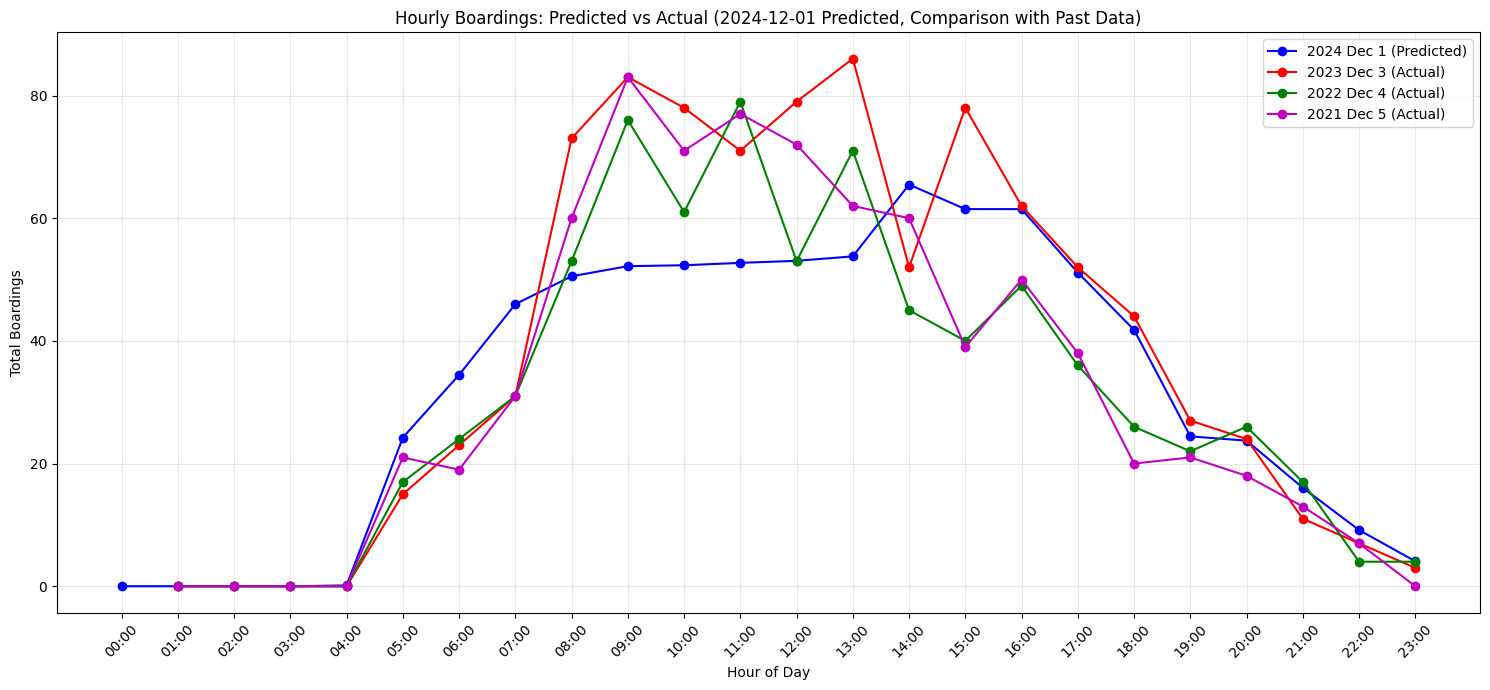

MAE (2024 Prediction vs 2023 Actual): 11.19


In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import cross_val_score, GridSearchCV
import matplotlib.pyplot as plt

# 1. 데이터 로드
train = pd.read_csv('/content/updated_file.csv')
train['날짜'] = pd.to_datetime(train['날짜'])

# 2. 특정 STATION_NO 및 주말 필터링
train = train[(train['STATION_NO'] == 1102) & (train['IS_WEEKEND'] == 1)]

# 3. 학습 데이터 필터링
def filter_training_data(df, start_date, end_date):
    return df[(df['날짜'] >= start_date) & (df['날짜'] <= end_date)]

data_2021 = filter_training_data(train, '2021-01-01', '2021-12-31')
data_2022 = filter_training_data(train, '2022-01-01', '2022-12-31')
data_2023 = filter_training_data(train, '2023-01-01', '2023-12-31')
data_2024 = filter_training_data(train, '2024-01-01', '2024-09-30')

# 4. 강수량 여부 변수 추가
train['rainfall_flag'] = (train['강수량(mm)'] > 0).astype(int)

# 5. 시간대별 데이터 준비
def prepare_hourly_data(data):
    hourly_data = []
    for _, row in data.iterrows():
        date = row['날짜']
        for hour in range(24):
            hour_col = f'CNT{hour:02d}'
            if hour_col in row:
                hourly_data.append({
                    'datetime': f"{date.strftime('%Y-%m-%d')} {hour:02d}:00:00",
                    'hour': hour,
                    'count': row[hour_col],
                    'sin_hour': np.sin(2 * np.pi * hour / 24),
                    'cos_hour': np.cos(2 * np.pi * hour / 24),
                    'rush_hour': 1 if (6 <= hour <= 9) or (17 <= hour <= 19) else 0,
                    'rainfall_flag': row['강수량(mm)'],
                    'is_holiday': row['IS_HOLIDAY'],
                    '평균기온': row['평균기온(℃)'],
                    '최저기온': row['최저기온(℃)'],
                    '최고기온': row['최고기온(℃)']
                })
    result = pd.DataFrame(hourly_data)
    result['datetime'] = pd.to_datetime(result['datetime'], format='%Y-%m-%d %H:%M:%S')
    return result

data_2021_hourly = prepare_hourly_data(data_2021)
data_2022_hourly = prepare_hourly_data(data_2022)
data_2023_hourly = prepare_hourly_data(data_2023)
data_2024_hourly = prepare_hourly_data(data_2024)

# 6. 학습 데이터 병합
train_data = pd.concat([data_2021_hourly, data_2022_hourly, data_2023_hourly, data_2024_hourly], ignore_index=True)
# 7. 데이터 정규화
scaler = StandardScaler()
features = ['hour', 'sin_hour', 'cos_hour', 'rush_hour', 'rainfall_flag', 'is_holiday',
            '평균기온', '최저기온', '최고기온']
train_data[features] = scaler.fit_transform(train_data[features])

# 8. Random Forest 모델 학습
X = train_data[features]
y = train_data['count']

# 교차 검증 및 하이퍼파라미터 튜닝
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
grid_search = GridSearchCV(RandomForestRegressor(random_state=42), param_grid, cv=3, scoring='neg_mean_absolute_error')
grid_search.fit(X, y)
print("Best Parameters:", grid_search.best_params_)

rf_model = grid_search.best_estimator_

# 9. 2024년 12월 1일 예측 데이터 생성
hours = list(range(24))
test_data_2024 = pd.DataFrame({
    'hour': hours,
    'sin_hour': np.sin(2 * np.pi * np.array(hours) / 24),
    'cos_hour': np.cos(2 * np.pi * np.array(hours) / 24),
    'rush_hour': [(1 if (6 <= h <= 9) or (17 <= h <= 19) else 0) for h in hours],
    'rainfall_flag': 0,  # 임의 데이터 (강수량 없음으로 가정)
    'is_holiday': 1,  # 일요일이므로 휴일로 설정
    '평균기온': 6,  # 임의 데이터 (평균 기온 추정치)
    '최저기온': 4,  # 임의 데이터
    '최고기온': 12  # 임의 데이터
})
test_data_2024[features] = scaler.transform(test_data_2024[features])  # 정규화 적용

rf_predictions_2024 = rf_model.predict(test_data_2024)

# 10. 시각화 (2024년 12월 1일 예측값)
plt.figure(figsize=(15, 7))
plt.plot(hours, rf_predictions_2024, 'b-', label='2024 Dec 1 (Predicted)', marker='o')

# 비교: 2023년 12월 3일, 2022년 12월 4일, 2021년 12월 5일 실제 데이터
data_2023_actual = prepare_hourly_data(filter_training_data(train, '2023-12-03', '2023-12-03'))
data_2022_actual = prepare_hourly_data(filter_training_data(train, '2022-12-04', '2022-12-04'))
data_2021_actual = prepare_hourly_data(filter_training_data(train, '2021-12-05', '2021-12-05'))

plt.plot(data_2023_actual['hour'], data_2023_actual['count'], 'r-', label='2023 Dec 3 (Actual)', marker='o')
plt.plot(data_2022_actual['hour'], data_2022_actual['count'], 'g-', label='2022 Dec 4 (Actual)', marker='o')
plt.plot(data_2021_actual['hour'], data_2021_actual['count'], 'm-', label='2021 Dec 5 (Actual)', marker='o')

plt.title('Hourly Boardings: Predicted vs Actual (2024-12-01 Predicted, Comparison with Past Data)')
plt.xlabel('Hour of Day')
plt.ylabel('Total Boardings')
plt.grid(True, alpha=0.3)
plt.legend()
plt.xticks(hours, [f'{h:02d}:00' for h in hours], rotation=45)
plt.tight_layout()
plt.show()

# 11. MAE 계산 (2023년과의 비교)
min_length_2023 = min(len(data_2023_actual['count']), len(rf_predictions_2024))
mae_2023_comparison = mean_absolute_error(data_2023_actual['count'][:min_length_2023], rf_predictions_2024[:min_length_2023])
print(f"MAE (2024 Prediction vs 2023 Actual): {mae_2023_comparison:.2f}")

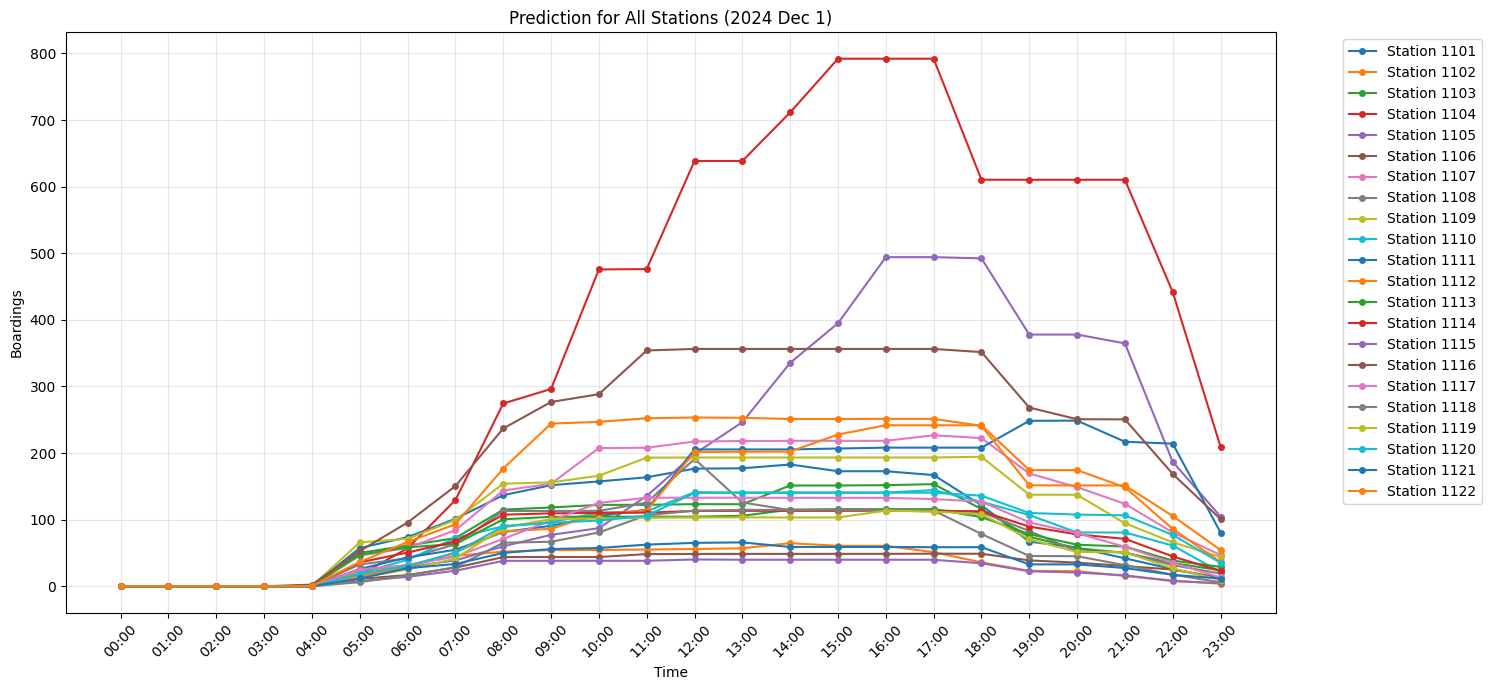

In [ ]:
# 개발 환경: Google Colab
# Python 3.10.12
# Libraries: pandas 2.1.3, numpy 1.23.5, scikit-learn 1.2.2, matplotlib 3.7.1

import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
import pickle

# 1. 데이터 로드
train = pd.read_csv('updated_file.csv')
train['날짜'] = pd.to_datetime(train['날짜'])

# 2. 모든 역에 대한 예측 수행
stations = sorted(train['STATION_NO'].unique())
predictions = {}
mae_values = {}

# 3. 시간대별 데이터 준비 함수
def prepare_hourly_data(data):
    hourly_data = []
    for _, row in data.iterrows():
        date = row['날짜']
        for hour in range(24):
            hour_col = f'CNT{hour:02d}'
            if hour_col in row:
                hourly_data.append({
                    'datetime': pd.to_datetime(f"{date.strftime('%Y-%m-%d')} {hour:02d}:00:00"),
                    'hour': hour,
                    'count': row[hour_col],
                    'sin_hour': np.sin(2 * np.pi * hour / 24),
                    'cos_hour': np.cos(2 * np.pi * hour / 24),
                    'rush_hour': 1 if (6 <= hour <= 9) or (17 <= hour <= 19) else 0,
                    'rainfall_flag': row['강수량(mm)'],
                    'is_holiday': row['IS_HOLIDAY'],
                    '평균기온': row['평균기온(℃)'],
                    '최저기온': row['최저기온(℃)'],
                    '최고기온': row['최고기온(℃)']
                })
    return pd.DataFrame(hourly_data)

features = ['hour', 'sin_hour', 'cos_hour', 'rush_hour', 'rainfall_flag', 'is_holiday',
            '평균기온', '최저기온', '최고기온']

for station in stations:
    # 역별 데이터 필터링
    station_data = train[train['STATION_NO'] == station]
    station_data = station_data[station_data['IS_WEEKEND'] == 1]
    station_data['rainfall_flag'] = (station_data['강수량(mm)'] > 0).astype(int)

    # 학습 데이터 준비 (2021년부터 2024년 9월까지)
    train_data = station_data[station_data['날짜'] < '2023-12-10']
    train_data_hourly = prepare_hourly_data(train_data)

    # 데이터 정규화
    scaler = StandardScaler()
    train_data_hourly[features] = scaler.fit_transform(train_data_hourly[features])

    # Random Forest 모델 학습
    X = train_data_hourly[features]
    y = train_data_hourly['count']

    rf_model = RandomForestRegressor(max_depth=5, min_samples_leaf=4,
                                   min_samples_split=10, n_estimators=300,
                                   random_state=42)
    rf_model.fit(X, y)

    # 2024년 12월 1일 예측
    dec_1_2024 = pd.DataFrame({
        'hour': range(24),
        'sin_hour': np.sin(2 * np.pi * np.arange(24) / 24),
        'cos_hour': np.cos(2 * np.pi * np.arange(24) / 24),
        'rush_hour': [(1 if (6 <= h <= 9) or (17 <= h <= 19) else 0) for h in range(24)],
        'rainfall_flag': 0,
        'is_holiday': 1,
        '평균기온': 5,
        '최저기온': 0,
        '최고기온': 10
    })
    dec_1_2024[features] = scaler.transform(dec_1_2024[features])

    predictions[station] = rf_model.predict(dec_1_2024[features])

    # MAE 계산
data_2023 = prepare_hourly_data(station_data[station_data['날짜'] == '2023-12-03'])
if len(data_2023) == 24:  # 24시간 데이터가 모두 있는 경우에만 MAE 계산
    mae_values[station] = mean_absolute_error(data_2023['count'], predictions[station])
else:
    # 데이터가 없는 경우 가장 가까운 날짜의 데이터 사용
    date_diffs = abs(station_data['날짜'] - pd.to_datetime('2023-12-03'))
    nearest_date = station_data.loc[date_diffs.idxmin(), '날짜']
    data_2023 = prepare_hourly_data(station_data[station_data['날짜'] == nearest_date])
    if len(data_2023) == 24:
        mae_values[station] = mean_absolute_error(data_2023['count'], predictions[station])

# 예측 결과를 저장할 리스트 생성
result_list = []

for station in stations:
    row_data = {
        'BUSINESS_DAY': '20241201',
        'STATION_NO': station
    }
    # 각 시간대별 예측값 추가 (CNT01~CNT23, CNT00)
    for hour in range(24):
        row_data[f'CNT{str(hour).zfill(2)}'] = int(predictions[station][hour])

    # RIDE_DEMAND 추가 (24시간 예측값의 합계)
    row_data['RIDE_DEMAND'] = sum(int(predictions[station][hour]) for hour in range(24))

    result_list.append(row_data)

# 리스트를 DataFrame으로 변환
result_df = pd.DataFrame(result_list)

# 컬럼 순서 지정
columns = ['BUSINESS_DAY', 'STATION_NO'] + [f'CNT{str(i).zfill(2)}' for i in range(24)] + ['RIDE_DEMAND']
result_df = result_df[columns]

# 결과 정렬
result_df = result_df.sort_values('STATION_NO').reset_index(drop=True)

# CSV 파일로 저장
result_df.to_csv('prediction.csv', index=False)

# 시각화 부분 수정
plt.figure(figsize=(15, 7))
for station in stations:
    plt.plot(range(24), predictions[station], '-',
             label=f'Station {station}', marker='o', markersize=4)

plt.title('Prediction for All Stations (2024 Dec 1)')
plt.xlabel('Time')  # x축 레이블 변경
plt.ylabel('Boardings')  # y축 레이블 변경
plt.grid(True, alpha=0.3)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(range(24), [f'{str(h).zfill(2)}:00' for h in range(24)], rotation=45)
plt.tight_layout()
plt.savefig('prediction_plot.png', bbox_inches='tight')
plt.show()

# MAE 출력
print("\n")  # 그래프와 MAE 값 사이 줄바꿈
for station in sorted(mae_values.keys()):
    print(f"Station {station} MAE: {mae_values[station]:.2f}")

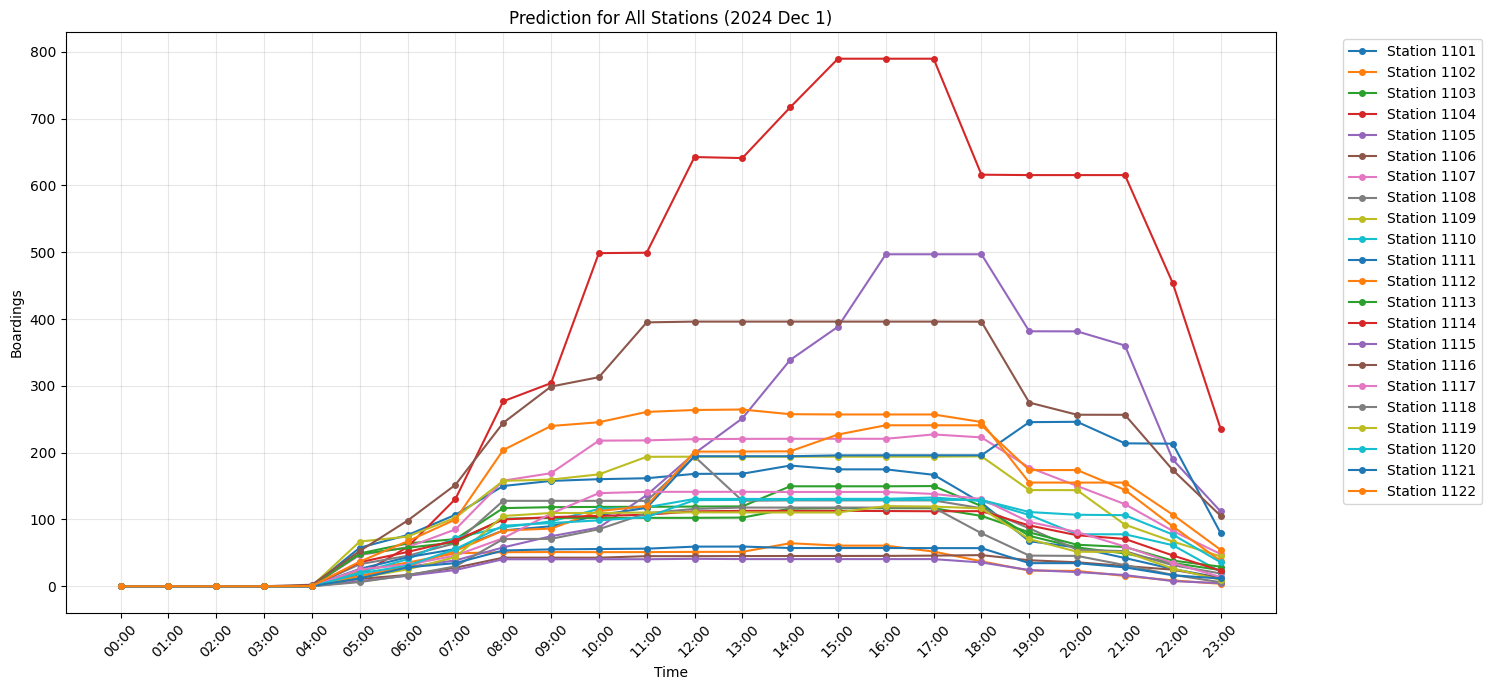


Station-wise MAE values:


In [ ]:
# 개발 환경: Google Colab
# Python 3.10.12
# Libraries: pandas 2.1.3, numpy 1.23.5, scikit-learn 1.2.2, matplotlib 3.7.1

import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
import pickle

# 1. 데이터 로드
train = pd.read_csv('updated_file.csv')
train['날짜'] = pd.to_datetime(train['날짜'])

# 2. 모든 역에 대한 예측 수행
stations = sorted(train['STATION_NO'].unique())
predictions = {}
mae_values = {}

# 3. 시간대별 데이터 준비 함수
def prepare_hourly_data(data):
    hourly_data = []
    for _, row in data.iterrows():
        date = row['날짜']
        for hour in range(24):
            hour_col = f'CNT{hour:02d}'
            if hour_col in row:
                hourly_data.append({
                    'datetime': pd.to_datetime(f"{date.strftime('%Y-%m-%d')} {hour:02d}:00:00"),
                    'hour': hour,
                    'count': row[hour_col],
                    'sin_hour': np.sin(2 * np.pi * hour / 24),
                    'cos_hour': np.cos(2 * np.pi * hour / 24),
                    'rush_hour': 1 if (6 <= hour <= 9) or (17 <= hour <= 19) else 0,
                    'rainfall_flag': row['강수량(mm)'],
                    'is_holiday': row['IS_HOLIDAY'],
                    '평균기온': row['평균기온(℃)'],
                    '최저기온': row['최저기온(℃)'],
                    '최고기온': row['최고기온(℃)']
                })
    return pd.DataFrame(hourly_data)

features = ['hour', 'sin_hour', 'cos_hour', 'rush_hour', 'rainfall_flag', 'is_holiday',
            '평균기온', '최저기온', '최고기온']

for station in stations:
    # 역별 데이터 필터링
    station_data = train[train['STATION_NO'] == station]
    station_data = station_data[station_data['IS_WEEKEND'] == 1]
    station_data['rainfall_flag'] = (station_data['강수량(mm)'] > 0).astype(int)

    # 각 연도별 데이터 필터링
    data_2021 = station_data[(station_data['날짜'] >= '2021-01-01') & (station_data['날짜'] <= '2021-12-10')]
    data_2022 = station_data[(station_data['날짜'] >= '2022-01-01') & (station_data['날짜'] <= '2022-12-10')]
    data_2023 = station_data[(station_data['날짜'] >= '2023-01-01') & (station_data['날짜'] <= '2023-12-10')]

    # 데이터 준비
    data_2021_hourly = prepare_hourly_data(data_2021)
    data_2022_hourly = prepare_hourly_data(data_2022)
    data_2023_hourly = prepare_hourly_data(data_2023)

    # 학습 데이터 병합
    train_data_hourly = pd.concat([data_2021_hourly, data_2022_hourly, data_2023_hourly], ignore_index=True)

    # 데이터 정규화
    scaler = StandardScaler()
    train_data_hourly[features] = scaler.fit_transform(train_data_hourly[features])

    # Random Forest 모델 학습
    X = train_data_hourly[features]
    y = train_data_hourly['count']

    rf_model = RandomForestRegressor(max_depth=5, min_samples_leaf=4,
                                   min_samples_split=10, n_estimators=300,
                                   random_state=42)
    rf_model.fit(X, y)

    # 2024년 12월 1일 예측
    dec_1_2024 = pd.DataFrame({
        'hour': range(24),
        'sin_hour': np.sin(2 * np.pi * np.arange(24) / 24),
        'cos_hour': np.cos(2 * np.pi * np.arange(24) / 24),
        'rush_hour': [(1 if (6 <= h <= 9) or (17 <= h <= 19) else 0) for h in range(24)],
        'rainfall_flag': 0,
        'is_holiday': 1,
        '평균기온': 5,
        '최저기온': 0,
        '최고기온': 10
    })
    dec_1_2024[features] = scaler.transform(dec_1_2024[features])

    predictions[station] = rf_model.predict(dec_1_2024[features])

    # MAE 계산
    data_2023 = prepare_hourly_data(station_data[station_data['날짜'] == '2023-12-03'])
    if len(data_2023) == 24:
        mae_values[station] = mean_absolute_error(data_2023['count'], predictions[station])

# 예측 결과를 저장할 리스트 생성
result_list = []

for station in stations:
    row_data = {
        'BUSINESS_DAY': '20241201',
        'STATION_NO': station
    }
    # 각 시간대별 예측값 추가 (CNT01~CNT23, CNT00)
    for hour in range(24):
        row_data[f'CNT{str(hour).zfill(2)}'] = int(predictions[station][hour])

    result_list.append(row_data)

# 리스트를 DataFrame으로 변환
result_df = pd.DataFrame(result_list)

# 컬럼 순서 지정
columns = ['BUSINESS_DAY', 'STATION_NO'] + [f'CNT{str(i).zfill(2)}' for i in range(24)]
result_df = result_df[columns]

# 결과 정렬
result_df = result_df.sort_values('STATION_NO').reset_index(drop=True)

# CSV 파일로 저장
result_df.to_csv('prediction.csv', index=False)

# 시각화
plt.figure(figsize=(15, 7))
for station in stations:
    plt.plot(range(24), predictions[station], '-',
             label=f'Station {station}', marker='o', markersize=4)

plt.title('Prediction for All Stations (2024 Dec 1)')
plt.xlabel('Time')
plt.ylabel('Boardings')
plt.grid(True, alpha=0.3)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(range(24), [f'{str(h).zfill(2)}:00' for h in range(24)], rotation=45)
plt.tight_layout()
plt.savefig('prediction_plot.png', bbox_inches='tight')
plt.show()

# MAE 출력
print("\nStation-wise MAE values:")
for station in sorted(mae_values.keys()):
    print(f"Station {station} MAE: {mae_values[station]:.2f}")